In [7]:
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
import rasterio
import numpy as np

# Ścieżka do pliku TIFF obrazu Planet
file_path = 'C:/Users/delve/Downloads/inzynierka/Avon_range_psscene_analytic_sr_udm2/PSScene/20250709_163606_04_24b7_3B_AnalyticMS_SR.tif'

with rasterio.open(file_path) as src:
    print("Liczba kanałów:", src.count)
    nir_band = src.read(4)
    
    print(nir_band)

Liczba kanałów: 4
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [8]:

n_samples = 100
image_size = 256

# Initialize arrays for our training data
X_data = []
y_data = []

# Load all available satellite images
image_pattern = 'C:/Users/delve/Downloads/inzynierka/Avon_range_psscene_analytic_sr_udm2/PSScene/*_3B_AnalyticMS_SR.tif'
image_files = glob.glob(image_pattern)

for image_file in image_files:
    with rasterio.open(image_file) as src:
        # Read all bands
        image = src.read()
        # Reshape to (height, width, channels)
        image = np.moveaxis(image, 0, -1)
        # Resize to our target size if needed
        if image.shape[0] != image_size or image.shape[1] != image_size:
            image = tf.image.resize(image, (image_size, image_size))
        X_data.append(image)
        
        # For this example, we'll generate synthetic humidity values
        # In a real scenario, you would use actual ground measurements
        synthetic_humidity = np.random.uniform(30, 70)  # Random humidity between 30% and 70%
        y_data.append(synthetic_humidity)

X_data = np.array(X_data)
y_data = np.array(y_data)

# Normalize the input data
X_data = X_data / 65535.0  # Assuming 16-bit images

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [9]:
# Define the model architecture
model = models.Sequential([
    layers.Input(shape=(256, 256, 4)),  # 4 channels for multispectral data
    
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)  # Single output for humidity prediction
])

# Compile the model with appropriate loss function and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Mean Squared Error for regression
    metrics=['mae', 'mse']  # Track both Mean Absolute Error and Mean Squared Error
)

# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,682,145 (128.49 MB)

 Trainable params: 33,681,697 (128.49 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 3229.1548 - mae: 55.4382 - mse: 3229.1548 - val_loss: 2321.2786 - val_mae: 47.8716 - val_mse: 2321.2786
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 3229.1548 - mae: 55.4382 - mse: 3229.1548 - val_loss: 2321.2786 - val_mae: 47.8716 - val_mse: 2321.2786
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - loss: 77756.5938 - mae: 274.0764 - mse: 77756.5938 - val_loss: 2365.9111 - val_mae: 48.3361 - val_mse: 2365.9111
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - loss: 77756.5938 - mae: 274.0764 - mse: 77756.5938 - val_loss: 2365.9111 - val_mae: 48.3361 - val_mse: 2365.9111
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - loss: 3796.4824 - mae: 57.6449 - mse: 3796.4824 - val_loss: 2375.3379 - val_mae: 48.4351 - val_mse: 2375.3379
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - loss: 3796.4824 - mae: 57.6449 - mse: 3796.4824 - val_loss: 2375.3379 - val_mae: 48.4351 - val_mse: 2375.3379
Epoch 4/50
1/1 ━━━━━━━━━━━━━

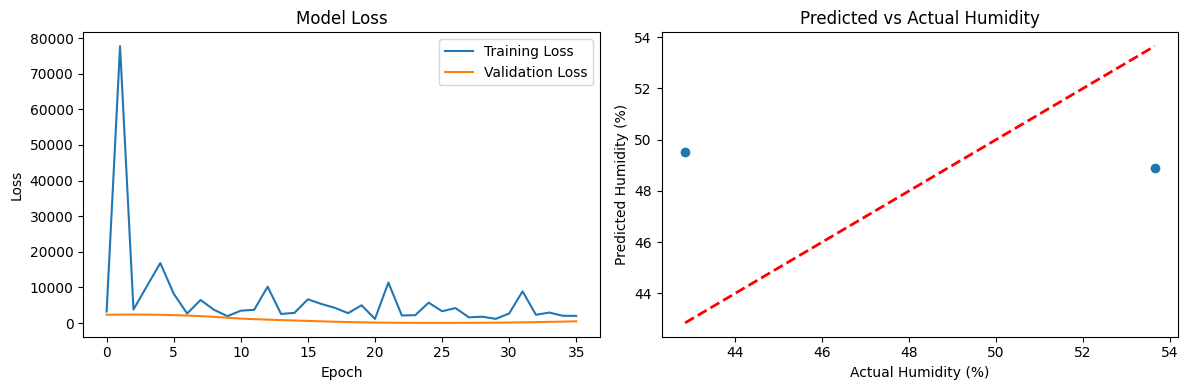

In [10]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

# Evaluate the model
test_loss, test_mae, test_mse = model.evaluate(X_val, y_val, verbose=0)
print(f'\nTest Mean Absolute Error: {test_mae:.2f}% humidity')
print(f'Test Mean Squared Error: {test_mse:.2f}')

# Make predictions on validation set
predictions = model.predict(X_val)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot predicted vs actual values
plt.subplot(1, 2, 2)
plt.scatter(y_val, predictions)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Humidity (%)')
plt.ylabel('Predicted Humidity (%)')
plt.title('Predicted vs Actual Humidity')

plt.tight_layout()
plt.show()